# Regression

> **Co-author**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)


**Prerequisites**

- [Applied Linear Algebra](../scientific/applied_linalg.ipynb)  
- [Optimization](../scientific/optimization.ipynb)  


**Outcomes**

- Recall linear regression from linear algebra  
- Know what feature engineering is and how feature engineering can be automated by neural networks  
- Understand the related concepts of overfitting and regularization  
- Understand lasso regression and its relation to linear regression  
- Understand regression forests as well as its relation to linear regression  
- Understand the basics of the multi-layer perceptron  
- Use scikit-learn to fit linear regression, lasso, regression forests, and multi-layer perceptron to data on housing prices near Seattle, WA  

## Outline

- [Regression](#Regression)  
  - [Introduction to Regression](#Introduction-to-Regression)  
  - [Linear Regression](#Linear-Regression)  
  - [Lasso Regression](#Lasso-Regression)  
  - [Random Forests](#Random-Forests)  
  - [Neural Networks](#Neural-Networks)  
  - [References](#References)  
  - [Exercises](#Exercises)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction to Regression

The goal of regression analysis is to provide accurate mapping from one or
more input variables (called features in machine learning or exogenous
variables in econometrics) to a continuous output variable (called the label or
target in machine learning and the endogenous variable in
econometrics).

In this lecture, we will study some of the most fundamental and widely-used
regression algorithms.

We will follow this same general pattern when we learn each algorithm:

- Describe the mathematical foundation for the algorithm  
- Use the [scikit-learn](https://scikit-learn.org/stable/) python package to
  apply the algorithm to a real world dataset on house prices in Washington state  

### Dataset

Let’s load the dataset and take a quick look at our task.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
plotly_template = qeds.themes.plotly_template()
colors = qeds.themes.COLOR_CYCLE

# We will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


This dataset contains sales prices on houses in King County (which
includes Seattle),
Washington, from May 2014 to May 2015.

The data comes from
[Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) . Variable definitions and additional documentation are available at that link.

In [3]:
X = df.drop(["price", "date", "id"], axis=1).copy()
# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [4]:
# notice the log here!
y = np.log(df["price"])
df["log_price"] = y
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

While we will be using all variables in `X` in our regression models,
we will explain some algorithms that use only the `sqft_living` variable.

Here’s what the log house price looks like against `sqft_living`:

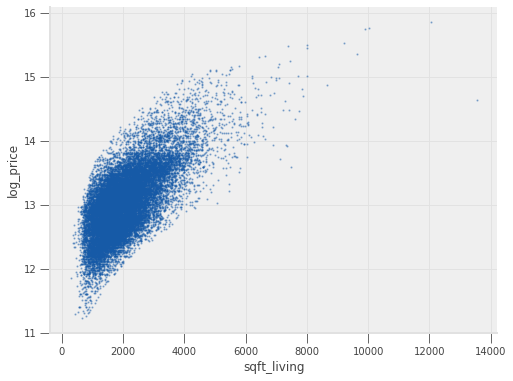

In [5]:
def var_scatter(df, ax=None, var="sqft_living"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="log_price", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(df);

## Linear Regression

Let’s dive in by studying the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms: linear regression.

Suppose we would like to predict the log of the sale price of a home, given
only the livable square footage of the home.

The linear regression model for this situation is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} + \epsilon
$$

$ \beta_0 $ and $ \beta_1 $ are called parameters (also coefficients or
weights). The machine learning algorithm is tasked with finding the parameter values
that best fit the data.

$ \epsilon $ is the error term. It would be unusual for the observed
$ \log(\text{price}) $ to be an exact linear function of
$ \text{sqft_living} $. The error term captures the deviation of
$ \log(\text{price}) $ from a linear function of $ \text{sqft_living} $.

The linear regression algorithm will choose the parameters that minimize the
*mean squared error* (MSE) function, which for our example is written.

$$
\frac{1}{N} \sum_{i=1}^N \left(\log(\text{price}_i) - (\beta_0 + \beta_1 \text{sqft_living}_i) \right)^2
$$

The output of this algorithm is the straight line (hence linear) that passes as
close to the points on our scatter chart as possible.

The `sns.lmplot` function below will plot our scatter chart and draw the
optimal linear regression line through the data.

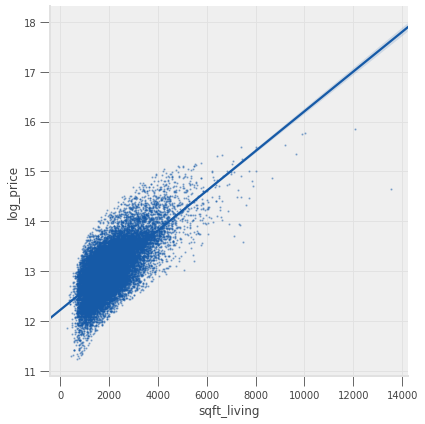

In [6]:
sns.lmplot(
    data=df, x="sqft_living", y="log_price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);

Let’s use `sklearn` to replicate the figure ourselves.

First, we fit the model.

In [7]:
# import
from sklearn import linear_model

# construct the model instance
sqft_lr_model = linear_model.LinearRegression()

# fit the model
sqft_lr_model.fit(X[["sqft_living"]], y)

# print the coefficients
beta_0 = sqft_lr_model.intercept_
beta_1 = sqft_lr_model.coef_[0]

print(f"Fit model: log(price) = {beta_0:.4f} + {beta_1:.4f} sqft_living")

Fit model: log(price) = 12.2185 + 0.0004 sqft_living


Then, we construct the plot.

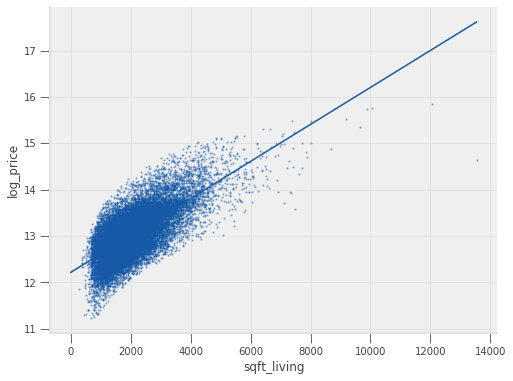

In [8]:
ax = var_scatter(df)

# points for the line
x = np.array([0, df["sqft_living"].max()])
ax.plot(x, beta_0 + beta_1*x)

We can call the `predict` method on our model to evaluate the model at
arbitrary points.

For example, we can ask the model to predict the sale price of a 5,000-square-foot home.

In [9]:
# Note, the argument needs to be two-dimensional. You'll see why shortly.
logp_5000 = sqft_lr_model.predict([[5000]])[0]
print(f"The model predicts a 5,000 sq. foot home would cost {np.exp(logp_5000):.2f} dollars")

The model predicts a 5,000 sq. foot home would cost 1486889.32 dollars



<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)



<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)

### Multivariate Linear Regression

Our example regression above is called a univariate linear
regression since it uses a single feature.

In practice, more features would be used.

Suppose that in addition to `sqft_living`, we also wanted to use the `bathrooms` variable.

In this case, the linear regression model is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} +
\beta_2 \text{bathrooms} + \epsilon
$$

We could keep adding one variable at a time, along with a new $ \beta_{j} $ coefficient for the :math:`j`th variable, but there’s an easier way.

Let’s write this equation in vector/matrix form as

$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_N)\end{bmatrix}}_Y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_N & \text{bathrooms}_N \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \epsilon
$$

Notice that we can add as many columns to $ X $ as we’d like and the linear
regression model will still be written $ Y = X \beta + \epsilon $.

The mean squared error loss function for the general model is

$$
\frac{1}{N} \sum_{i=1}^N (y_i - X_i \beta)^2 = \frac{1}{N} \| y - X \beta\|_2^2
$$

where $ || \cdot ||_2 $ is the [l2-norm](http://mathworld.wolfram.com/L2-Norm.html).

Let’s fit the linear regression model using all columns in `X`.

In [10]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We just fit a model with 18 variables – just as quickly and easily as
fitting the model with 1 variable!

Visualizing a 18-dimensional model is rather difficult, but just so we can see how the
extra features changed our model, let’s make the log price vs `sqft_living`
one more time – this time including the prediction from both of our linear models.

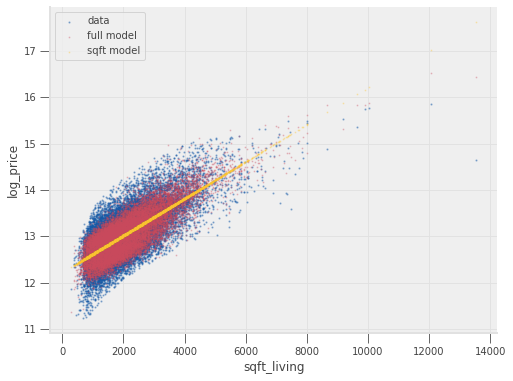

In [11]:
ax = var_scatter(df)

def scatter_model(mod, X, ax=None, color=colors[1], x="sqft_living"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax

scatter_model(lr_model, X, ax, color=colors[1])
scatter_model(sqft_lr_model, X[["sqft_living"]], ax, color=colors[2])
ax.legend(["data", "full model", "sqft model"])


<a id='exercise-2'></a>
> See exercise 3 in the [*exercise list*](#exerciselist-0)

### Nonlinear Relationships in Linear Regression

While it sounds like an oxymoron, a linear regression model can actually include non-linear features.

The distinguishing feature of the linear regression model is that each
prediction is generated by taking the dot product (a linear operator) between a
feature vector (one row of $ X $) and a coefficient vector ($ \beta $).

There is, however, no restriction on what element we include in our feature
vector.

Let’s consider an example…

Starting from the `sqft_living`-only model, suppose we have a hunch that we
should also include the *fraction of square feet above ground*.

This last variable can be computed as `sqft_above / sqft_living`.

This second feature is nonlinear, but could easily be included as a column in
`X`.

Let’s see this in action.

In [12]:
X2 = X[["sqft_living"]].copy()
X2["pct_sqft_above"] = X["sqft_above"] / X["sqft_living"]

sqft_above_lr_model = linear_model.LinearRegression()
sqft_above_lr_model.fit(X2, y)

new_mse = metrics.mean_squared_error(y, sqft_above_lr_model.predict(X2))
old_mse = metrics.mean_squared_error(y, sqft_lr_model.predict(X2[["sqft_living"]]))
print(f"The mse changed from {old_mse:.4f} to {new_mse:.4f} by including our new feature")

The mse changed from 0.1433 to 0.1430 by including our new feature



<a id='exercise-3'></a>
> See exercise 4 in the [*exercise list*](#exerciselist-0)


Determining which columns belong in $ X $ is called *feature
engineering* and is a large part of a machine learning practitioner’s job.

You may recall from (or will see in) your econometrics course(s) that
choosing which control variables to include in a regression model
is an important part of applied research.

### Interpretability

Before moving to our next regression model, we want to broach the idea of
the **interpretability** of models.

An interpretable model is one for which we can analyze the
coefficients to explain why it makes its predictions.

Recall $ \beta_0 $ and $ \beta_1 $ from the univariate model.

The interpretation of the model is that $ \beta_0 $ captures the notion of
the average or starting house price and $ \beta_1 $ is the additional value
per square foot.

Concretely, we have

In [13]:
beta_0, beta_1

(12.218464096380853, 0.0003987465387451507)

which means that our model predicts the log price of a house to be 12.22, plus
an additional 0.0004 for every square foot.

Using more exotic machine learning methods might potentially be more accurate but
less interpretable.

The accuracy vs interpretability tradeoff is a hot discussion topic, especially relating
to concepts like machine learning ethics. This is something you
should be aware of as you continue to learn about these techniques.

## Lasso Regression

Lasso regression is very closely related to linear regression.

The lasso model also generates predictions using $ y = X \beta $ but
optimizes over a slightly different loss function.

The optimization problem solved by lasso regression can be written as

$$
\min_{\beta} {|| X \beta - y||_2}^2 + \underbrace{\alpha {|| \beta ||_1}}_{\text{new part}}
$$

where $ || a ||_1 = \sum_{i=1}^N | a_i| $ is the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) and $ \alpha $ is called the regularization parameter.

The additional term penalizes large coefficients and in practice, effectively sets coefficients to zero
for features that are not informative about the
target.

Let’s see an example of what this looks like using the full feature set in
`X`.

In [14]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), lr_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
bedrooms,-0.000000e+00,-1.220820e-02
bathrooms,0.000000e+00,6.912370e-02
sqft_living,3.007615e-04,9.573470e-05
sqft_lot,2.736772e-07,4.711823e-07
floors,0.000000e+00,7.515336e-02
waterfront,0.000000e+00,3.711951e-01
view,0.000000e+00,6.040466e-02
condition,0.000000e+00,6.263658e-02
grade,0.000000e+00,1.589338e-01
sqft_above,-0.000000e+00,4.022408e-05


Notice that many coefficients from the lasso regression have been set to
zero.

The intuition here is that the corresponding features hadn’t provided
enough predictive power to be worth considering alongside the other features.

The default value for the $ \alpha $ parameter is 1.0.

Larger $ \alpha $ values cause coefficients to shrink (and maybe
additional ones to be thrown out).

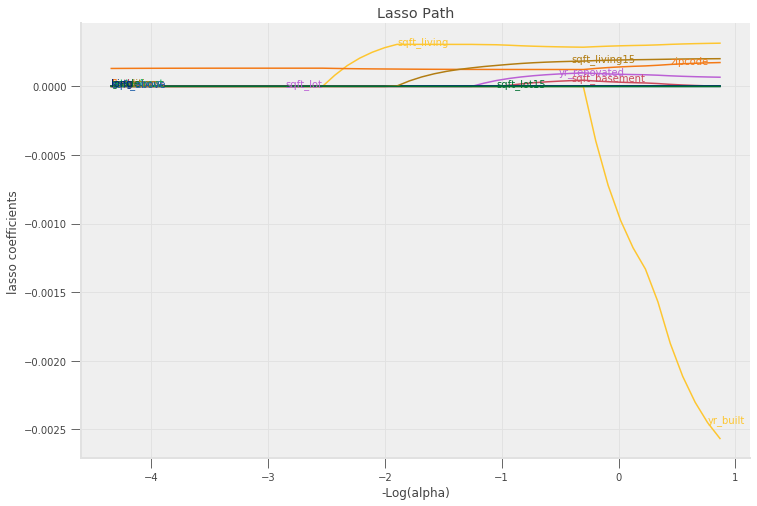

In [15]:
# Compute lasso for many alphas (the lasso path)
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=alphas, fit_intercept=True, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
colors = cycle(qeds.themes.COLOR_CYCLE)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, colors, list(X)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

### Overfitting and Regularization

You might be wondering, “Why would we ever want to throw variables out,
can’t that only hurt our model?”

The primary answer: it helps us avoid a common issue called **overfitting**.

Overfitting occurs when a model that specializes its coefficients too much on the
data it was trained on, and only to perform poorly when predicting on data
outside the training set.

The extreme example of overfitting is a model that can perfectly memorize the
training data, but can do no better than just randomly guess when predicting
on a new observation.

The techniques applied to reduce overfitting are known as **regularization**.

Regularization is an attempt to limit a model’s ability to specialize too narrowly
on training data (e.g. limit overfitting) by penalizing extreme values of the
model’s parameters.

The additional term in the lasso regression loss function ($ \alpha ||\beta||_1 $)
is a form of regularization.

Let’s demonstrate the overfitting and regularization phenomenon on our housing
price data as follows:

1. Split the data set into training and testing subsets. We will use the first 50 observations for training and the rest for testing.  
1. Fit the linear regression model and report MSE on training and testing datasets.  
1. Fit the lasso model and report the same statistics.  

In [16]:
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

n_test = 50
X_train = X.iloc[:n_test, :]
X_test = X.iloc[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

fit_and_report_mses(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mse_train': 0.05545627171577329, 'mse_test': 0.6705205330641264}

In [17]:
fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)

{'mse_train': 0.10629195024125099, 'mse_test': 0.2910434823708493}

Notice how the MSE on the training dataset was smaller for the linear model
without the regularization, but the MSE on the test dataset was much
higher.

This strongly suggests that the linear regression model was
overfitting.

The regularization parameter has a large impact on overfitting.

Text(-2.368878992199555, 0.2249868810554537, 'train')

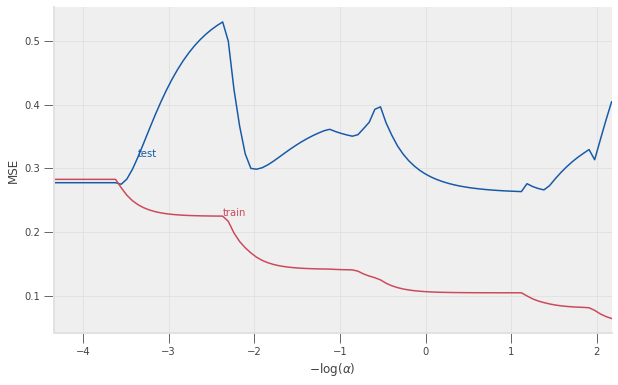

In [18]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
fig, ax = plt.subplots(figsize=(10,6))
colors = qeds.themes.COLOR_CYCLE
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

### Cross-validation of Regularization Parameter

As you can see in the figure above, the regularization parameter has a
large impact on MSE in the test data.

Moreover, the relationship between the test data MSE and $ \alpha $ is
complicated and non-monotonic.

One popular method for choosing the regularization parameter is cross-validation.

Roughly speaking, cross-validation splits the dataset into many training/testing
subsets, then chooses the regularization parameter value that minimizes the
average MSE.

More precisely, k-fold cross-validation does the following:

1. Partition the dataset randomly into k subsets/”folds”.  
1. Compute $ MSE_j(\alpha)= $ mean squared error in j-th subset
  when using the j-th subset as test data, and other k-1 as training
  data.  
1. Minimize average (across folds) MSE $ \min_\alpha \frac{1}{k}
  \sum_{j=1}^k MSE_j(\alpha) $.  


The following code plots 5-fold, cross-validated MSE as a function of
$ \alpha $, using the same training data as above.

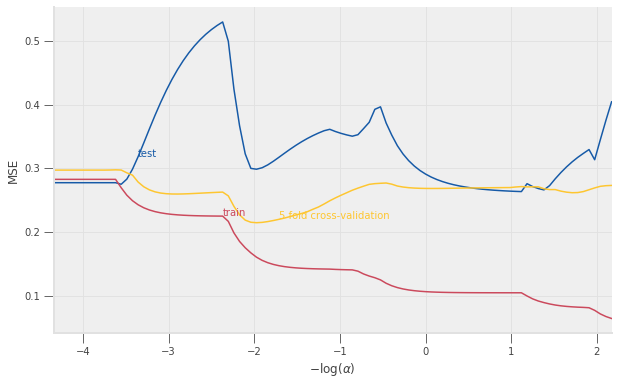

In [19]:
from sklearn.model_selection import cross_val_score
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

scikit learn also includes methods to automate the above and select
$ \alpha $.

In [20]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

-1.9732104006516824

### Holdout

Practitioners often use another technique to avoid overfitting, called
*holdout*.

We demonstrated an extreme example of applying holdout above when we used only
the first 50 observations to train our models.

In general, good practice is to split the entire dataset into a training subset
and testing or validation subset.

The splitting should be done randomly. It should leave enough data in the
training dataset to produce a good model, but also enough in the validation
subset to determine the degree of overfitting.

There aren’t hard and fast rules for how much data to put in each subset, but a
reasonable default uses 75% of the data for training and the
rest for testing.

As in the example above, the training data is often further split
while selecting regularization parameters with cross-validation.

The `sklearn` function `model_selection.train_test_split` will do this for you:

In [21]:
# note test_size=0.25 is the default value, but is shown here so you
# can see how to change it
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


<a id='exercise-4'></a>
> See exercise 5 in the [*exercise list*](#exerciselist-0)

### Lasso in Econometrics

Lasso is becoming increasingly popular in economics, partially due to
the work of Victor Chernozhukov and his coauthors.

In econometrics, the goal is typically to estimate some coefficient of interest or causal
effect, rather than obtaining the most precise prediction.

Among other things, this different goal affects how the regularization parameter
must be chosen.

[[regBC11]](#reg-belloni2011) and [[regCHS16]](#reg-hdm) are somewhat approachable introductions
to this area.

The latter of these two references includes an R package.

[[regCCD+18]](#reg-chernozhukov2018) reflects close to the state-of-art in this rapidly
advancing area.

## Random Forests

Random forests are also becoming increasingly popular in economics, thanks to the work of Susan Athey and her coauthors.

[[regAI17]](#reg-athey2017) gives a very brief overview of this work,
and [[regAI18]](#reg-athey2018) are video lectures and associated code aimed
at a broader audience.

### Regression Trees

To understand a forest, we must first understand trees.

We will begin by fitting a tree to this simulated data.

In [22]:
import numpy as np
# Simulate some data and plot it
n = 1000
Xsim = np.random.rand(n,2)
def Ey_x(x):
    return 1/3*(np.sin(5*x[0])*np.sqrt(x[1])*np.exp(-(x[1]-0.5)**2))

ysim = np.apply_along_axis(Ey_x, 1, Xsim) + np.random.randn(n)*0.1

In [23]:
import plotly.graph_objects as go

In [24]:
def surface_scatter_plot(X,y,f, xlo=0., xhi=1., ngrid=50,
                         width=860, height=700, f0=Ey_x, show_f0=False):
    scatter = go.Scatter3d(x=X[:,0],y=X[:,1],z=y,
                           mode='markers',
                           marker=dict(size=2, opacity=0.3)
    )
    xgrid = np.linspace(xlo,xhi,ngrid)
    ey = np.zeros((len(xgrid),len(xgrid)))
    ey0 = np.zeros((len(xgrid),len(xgrid)))
    colorscale = [[0, colors[0]], [1, colors[2]]]
    for i in range(len(xgrid)):
        for j in range(len(xgrid)):
            ey[j,i] = f([xgrid[i],xgrid[j]])
            ey0[j,i]= f0([xgrid[i],xgrid[j]])
    surface = go.Surface(x=xgrid, y=xgrid, z=ey, colorscale=colorscale, opacity=1.0)
    if (show_f0):
        surface0 = go.Surface(x=xgrid, y=xgrid, z=ey0, opacity=0.8, colorscale=colorscale)
        layers = [scatter, surface, surface0]
    else:
        layers = [scatter, surface]
    fig = go.FigureWidget(
        data=layers,
        layout = go.Layout(
            autosize=True,
            scene=dict(
                xaxis_title='X1',
                yaxis_title='X2',
                zaxis_title='Y'
            ),
            width=width,
            height=height,
            template=plotly_template,
        )
    )
    return fig

fig = surface_scatter_plot(Xsim, ysim, Ey_x)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
         …

We now fit a regression tree to this data and plot the predicted
regression surface.

In [25]:
from sklearn import tree
fitted_tree = tree.DecisionTreeRegressor(max_depth=3).fit(Xsim,ysim)
fig=surface_scatter_plot(
    Xsim, ysim, lambda x: fitted_tree.predict([x]), show_f0=True
)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
         …

As you can see, predictions from regression trees are piecewise-constant on rectangular regions. The boundaries of these regions are
determined by a decision tree. The following code displays the
decision graph.

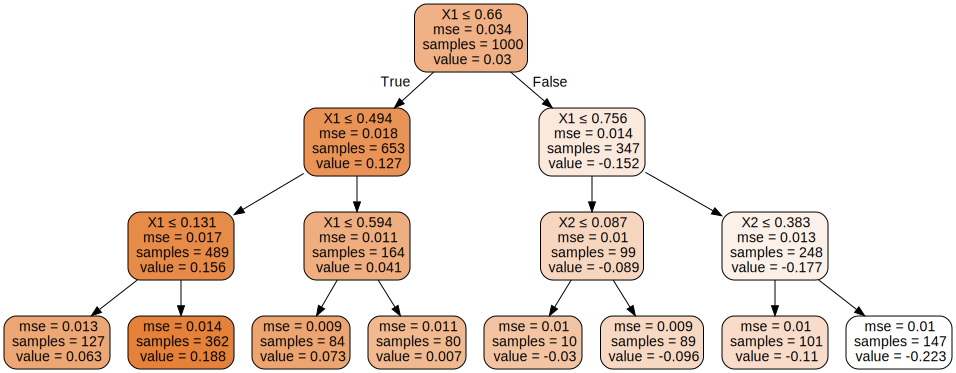

In [26]:
import graphviz
tree_graph = tree.export_graphviz(fitted_tree, out_file=None,
                                  feature_names=["X1", "X2"],
                                  filled=True, rounded=True,
                                  special_characters=True)
display(graphviz.Source(tree_graph))

Regression trees are formed iteratively.

We begin with a rectangular region $ R $ containing all values of
X.

We then choose a feature and location to split on, aiming to minimize MSE.

We then repeat to generate all the branches.

- For each region, solve  


$$
\min_{j,s} \left[ \min_{c_1} \sum_{i: x_{i,j} \leq s, x_i \in R}
    (y_i - c_1)^2 + \min_{c_2} \sum_{i: x_{i,j} > s, x_i \in R}
    (y_i - c_2)^2 \right]
$$

- Repeat with each of the two smaller rectangles.  
- Stop when $ |R| = $ some chosen minimum size or when depth of tree $ = $
  some chosen maximum.  
- Prune tree.  


$$
\min_{tree \subset T} \sum (\hat{f}(x)-y)^2 + \alpha|\text{terminal
   nodes in tree}|
$$

This tree-building algorithm has many variations, but every variation 1) shares some rule to decide on a splitting variable and location and 2) has a stopping rule (though not necessarily the same one).

For example, some algorithms stop splitting into new branches when the improvement
in MSE becomes small.

As with lasso, regression trees also involve some regularization.

In the above description, the minimum leaf size, maximum tree depth, and
$ \alpha $ in the pruning step serve as regularization
parameters.


<a id='exercise-5'></a>
> See exercise 6 in the [*exercise list*](#exerciselist-0)

In [27]:
# plot trees when varying some regularization parameter(s)


<a id='exercise-6'></a>
> See exercise 7 in the [*exercise list*](#exerciselist-0)


An advantage of regression trees (and random forests) is that they adapt
automatically to feature scales and units.

For example, including zip code in linear regression or lasso was a little
strange. While zip codes are numerical in value, they actually represent categorical
variables. (i.e. we can compute `10025` - `85001` (NYC and Phoenix), but the numerical difference is meaningless.)

Including an indicator or dummy variable for each zip code would make more sense.

Regression trees do not impose linearity or even monotonicity, so having the numeric zip code as a feature is
less harmful than it could have been.

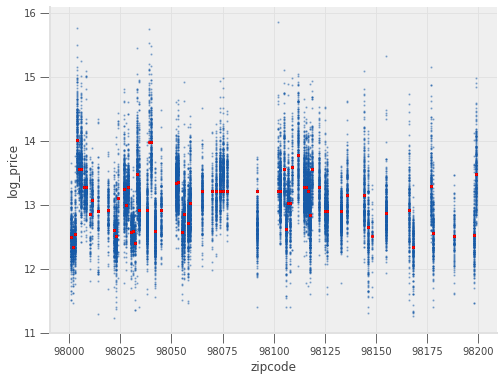

In [28]:
ax = var_scatter(df, var="zipcode")
zip_tree = tree.DecisionTreeRegressor(max_depth=10).fit(X[["zipcode"]],y)
scatter_model(zip_tree, X[["zipcode"]], ax, x="zipcode", color="red")

### Random Forests

A random forest is the average of many randomized regression trees.

Trees are randomized by:

- Fitting on randomly resampled subsets of data  
- Randomize features chosen for branching  


$$
\min_{j \in S,s} \left[ \min_{c_1} \sum_{i: x_{i,j} \leq s, x_i \in R}
    (y_i - c_1)^2 + \min_{c_2} \sum_{i: x_{i,j} > s, x_i \in R}
    (y_i - c_2)^2 \right]
$$

where $ S $ is a random subset of features.

Randomizing and averaging smooths out the predictions from individual
trees.

This improves predictions and reduces the variance of the predictions.

In [29]:
# example of forest for simulated data

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 10).fit(Xsim,ysim)
fig=surface_scatter_plot(Xsim,ysim,lambda x: forest.predict([x]),
                         show_f0=True)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
         …

Random forests generally produce more accurate predictions than any single
tree.

However, random forests have at least two downsides compared to trees:
longer computation time and more difficulty in interpretation.

We can no longer draw a single decision graph.

Instead, people often report “feature importance” for random forests.

Feature importance is the average MSE decrease caused by splits on each feature.

If a given feature has greater importance, the trees split on that feature more often and/or splitting on that
feature resulted in larger MSE decreases.

In [30]:
forest.feature_importances_

array([0.79771003, 0.20228997])


<a id='exercise-7'></a>
> See exercise 8 in the [*exercise list*](#exerciselist-0)

## Neural Networks

The final regression algorithm we will discuss in this lecture is a type of
neural network.

If you’re interested in this course, you have
probably heard about neural networks in the news or social media.

The purpose of this section is not to give an exhaustive overview of the topic,
but instead, to introduce you to a particular neural network model and present
it from a different perspective that hopefully complements materials you may later encounter.

### Mathematical Background

If linear regression is the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms, then the multi-layer perceptron (MLP) is the “Hello World” of neural
networks.

We’ll start with a single (hidden) layer MLP and then build up to the general form.

The prediction function for a single layer MLP is

$$
y = f_1(X w_1 + b_1) w_2 + b_2
$$

What we have here is *nested linear regression* (the $ (\cdot) w_i + b_i $
parts), separated by an *activation function* (the $ f_1 $).

Let’s unpack what happens, starting from our $ N_\text{samples} \times
N_\text{features} $ feature matrix $ X $.

1. First, $ X $ is multiplied by a coefficient matrix $ w_1 $. $ w_1 $ is often called the *weight matrix* or *weights* for short and has dimension $ N_{\text{features}} \times N_1 $.  
1. The vector $ b_1 $ is added to each row. $ b_1 $ is often called the *bias vector* or *bias* for short and has dimension $ N_1 \times 1 $.  
1. The function $ f_1 $ is then applied. Typically $ f_1 $ a non-linear function that is applied separately to each element. $ f_1 $ is called the *activation function*.  
1. The output is then multiplied by a weight matrix $ w_2 $ with dimension $ N_1 \times 1 $.  
1. Finally, a scalar $ b_2 $ is added to each row to generate the final prediction with dimension $ N_{\text{samples}} \times 1 $.  


The way we might write this in Python is:

```python
y = f(X@w1 + b1)@w2 + b2
```


In order to build an $ N $-hidden layer MLP, we will *nest* additional linear regressions
separated by activation functions.

The equation for this case is difficult to express, but has the following form

$$
y = f_{\cdots} \left(f_2(f_1(X w_1 + b_1) w_2 + b_2) w_{\cdots} + b_{\cdots} \right) w_{N+1} + b_{N+1}
$$

where the $ \cdots $ represents layers 3 to $ N $.

Notice the pattern of a linear regression ($ (\cdot) w + b $),
followed by applying an activation function ($ f $) at each step.


<a id='exercise-8'></a>
> See exercise 9 in the [*exercise list*](#exerciselist-0)


The loss or error function typically used when using an MLP for regression is
our now familiar mean squared error loss function:

$$
{||y - \hat{y}||_2}^2
$$

where $ \hat{y} $ is the output of the neural network.

Here, we fit a neural network to the same simulated data that we used
in the random forests section.

In [31]:
from sklearn import neural_network
nn = neural_network.MLPRegressor((6,), activation="logistic",
                                 verbose=True, solver="lbfgs",
                                 alpha=0.0).fit(Xsim,ysim)
fig=surface_scatter_plot(Xsim,ysim,lambda x: nn.predict([x]), show_f0=True)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
         …

We are nearly ready to test out a MLP on our housing data, but there are a few
more talking points to cover:

- [[regHSW89]](#reg-hornik1989) show that MLPs are universal approximators,
  meaning they are theoretically capable of approximating any
  function. This fact is sometimes stated as though it helps explain
  the exceptionally good predictive ability of neural networks. Do not
  be fooled by this fallacy. Many other methods are universal approximators,
  including regression trees and more classic statistical methods like
  kernel regression. The explanation for neural networks’ predictive success
  lies elsewhere.  <sup>[1](#rate)</sup>  
- The activation functions must be non-linear. If they were not,
  the MLP would be combining linear combinations of linear combinations and
  would therefore always be linear.  
- The hidden layer structure of an MLP allows it to automatically perform feature engineering.
  Contrastly,the example we had above required us to manually engineer
  the square feet above ground feature.  


<a id='rate'></a>
**[1]** Two facts about neural networks are relevant to their
predictive success: automatic feature engineering, as
mentioned above, and the ability of neural networks to
approximate a broad (but not quite universal) class of
functions with relatively few parameters. This gives
neural networks its fast statistical convergence
rate. Under appropriate assumptions, lasso, series
regression, and kernel regression share this fast
convergence rate property, but they lack automatic feature
engineering. On the other hand, random forests have automatic feature
engineering, but do not have a fast convergence rate.
Neural networks are somewhat unique in combining both
properties.
See
[these notes and references therein](http://faculty.arts.ubc.ca/pschrimpf/628/machineLearningAndCausalInference.html#2_introduction_to_machine_learning)
for more information about convergence rates.

### Application

Ok, now let’s try out our first neural network!

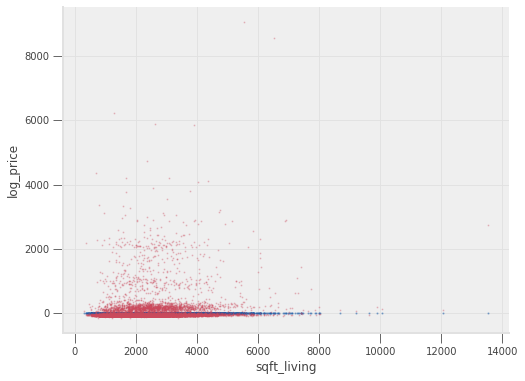

In [32]:
from sklearn import neural_network

X = df.drop(["price", "date", "id", "log_price"], axis=1).copy()
for col in list(X):
    X[col] = X[col].astype(float)
y = np.log(df["price"])

# two hidden layers, with N1=30 and N2=20
nn_model = neural_network.MLPRegressor((30, 20))
nn_model.fit(X, y)

ax = var_scatter(df)
scatter_model(nn_model, X, ax=ax)

Wow! That plot looks horrible. Let’s check the MSE.

In [33]:
mse_nn = metrics.mean_squared_error(y, nn_model.predict(X))
mse_nn / metrics.mean_squared_error(y, lr_model.predict(X))

1314195.6818284579

So… after all that talk about neural networks being all-powerful, our neural network above
produced a mean squared error which was tens of thousands of times larger than the
MSE from a linear regression!

### Input Scaling

The issue here is that neural networks are extremely sensitive to the scale
(both relative and absolute) of the input features.

The reasons for why are a bit beyond the scope of this lecture, but the main
idea is that the training procedure pays too much attention to relatively larger
features (relative scale) and becomes unstable if features are very large
(absolute scale).

A common technique to overcome this issue is to scale each variable so that the
observations have a mean of 0 and a standard deviation of 1.

This is known as scaling or normalizing the inputs.


<a id='exercise-9'></a>
> See exercise 10 in the [*exercise list*](#exerciselist-0)


If we decide to scale our variables, we must remember to apply the same
transformation at prediction time as we did when we fit the model.

In practice, we must do three things:

1. Store the mean and standard deviation of each feature in the training set.  
1. Subtract each feature’s mean from the training data and then divide by the feature’s standard deviation before fitting.  
1. Subtract the *training data’s* mean and divide by *training data’s* standard deviation for all prediction inputs.  


Applying the transformation to the prediction data is easily forgotten, so this is a tedious and
somewhat error-prone process.

Thankfully, scikit-learn has a way to automate the process and ensure that it is
always applied.

Let’s see an example:

In [34]:
from sklearn import preprocessing, pipeline

# the pipeline defines any number of steps that will be applied
# to transform the `X` data and then a final step that is a model
# we can use for prediction
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((30, 20))  # put your favorite model here
)

# We can now use `model` like we have used our other models all along
# Call fit
nn_scaled_model.fit(X, y)

# Call predict
mse_nn_scaled = metrics.mean_squared_error(y, nn_scaled_model.predict(X))

print(f"Unscaled mse {mse_nn}")
print(f"Scaled mse {mse_nn_scaled}")

Unscaled mse 83681.53182182509
Scaled mse 0.02951150106057874


There we have it, much better. This is the smallest MSE we have seen so far.

A scatter plot of the predictions looks very similar to the observed prices.

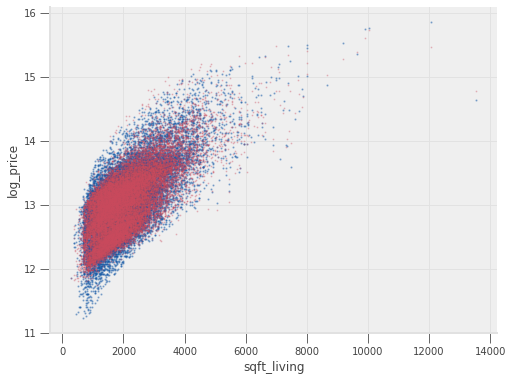

In [35]:
ax = var_scatter(df)
scatter_model(nn_scaled_model, X, ax=ax)

### Tradeoffs

So we’ve seen that neural networks are very flexible and can approximate highly
nonlinear functions – but they have a few cons.

We’ll discuss a few of them here.

- **Interpretability**: Unlike linear regression or lasso, neural
  networks are not easily interpretable. We could look at the $ w $
  matrices or $ b $ vectors, but the nested composition and
  nonlinear activation functions make it very difficult to interpret
  just how each coefficient impacts the output. In settings like
  making economic policy recommendations or decisions with ethical consequences
  (e.g. approving loans, screening),
  the lack of interpretability can be a non-starter.  
- **Efficiency/time**: Neural networks require more computational
  power to evaluate (generate predictions) and are orders of magnitude
  more expensive to train than classical machine learning
  methods.  
- **Automated feature engineering**: The nested linear regressions
  allow neural networks to learn data features that are
  composed of arbitrary linear combinations of the original feature
  set. The non-linear activation functions allow the network to learn
  arbitrary non-linear features. Manual feature engineering is based
  largely on the researchers intuition, as well as a fair amount of trial and
  error. Determining the proper features that allow for more
  explanatory power without overfitting is very difficult. Neural
  networks automate that process by using the data itself to guide the
  training process and select features that satisfy accuracy and
  regularization conditions.  
- **Overfitting**: Neural networks’ flexibility and explanatory
  power make them easy to accidentally overfit. When training neural
  networks, the various approaches to regularization should be studied and evaluated,
  especially when building networks used for decision-making.  



<a id='exercise-10'></a>
> See exercise 11 in the [*exercise list*](#exerciselist-0)

In [36]:
# your code here

## References

Two good text books covering the above regression methods are
[[regFHT09]](#reg-friedman2008) and [[regEH16]](#reg-efron2016)

<a id='reg-athey2018'></a>
\[regAI18\] Susan Athey and Guido Imbens. Machine learning and econometrics. 2018. URL: [https://www.aeaweb.org/conference/cont-ed/2018-webcasts](https://www.aeaweb.org/conference/cont-ed/2018-webcasts).

<a id='reg-athey2017'></a>
\[regAI17\] Susan Athey and Guido W. Imbens. The state of applied econometrics: causality and policy evaluation. *Journal of Economic Perspectives*, 31(2):3–32, May 2017. URL: [http://www.aeaweb.org/articles?id=10.1257/jep.31.2.3](http://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), [doi:10.1257/jep.31.2.3](https://doi.org/10.1257/jep.31.2.3).

<a id='reg-belloni2011'></a>
\[regBC11\] Alexandre Belloni and Victor Chernozhukov. *High Dimensional Sparse Econometric Models: An Introduction*, pages 121–156. Springer Berlin Heidelberg, Berlin, Heidelberg, 2011. URL: [https://doi.org/10.1007/978-3-642-19989-9_3](https://doi.org/10.1007/978-3-642-19989-9_3), [doi:10.1007/978-3-642-19989-9_3](https://doi.org/10.1007/978-3-642-19989-9_3).

<a id='reg-chernozhukov2018'></a>
\[regCCD+18\] Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, and James Robins. Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1):C1–C68, 2018. URL: [https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097), [arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097](https://arxiv.org/abs/https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097), [doi:10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

<a id='reg-hdm'></a>
\[regCHS16\] Victor Chernozhukov, Chris Hansen, and Martin Spindler. hdm: high-dimensional metrics. *R Journal*, 8(2):185–199, 2016. URL: [https://journal.r-project.org/archive/2016/RJ-2016-040/index.html](https://journal.r-project.org/archive/2016/RJ-2016-040/index.html).

<a id='reg-efron2016'></a>
\[regEH16\] Bradley Efron and Trevor Hastie. *Computer age statistical inference*. Volume 5. Cambridge University Press, 2016. URL: [https://web.stanford.edu/~hastie/CASI/](https://web.stanford.edu/~hastie/CASI/).

<a id='reg-friedman2008'></a>
\[regFHT09\] Jerome Friedman, Trevor Hastie, and Robert Tibshirani. *The elements of statistical learning*. Springer series in statistics, 2009. URL: [https://web.stanford.edu/~hastie/ElemStatLearn/](https://web.stanford.edu/~hastie/ElemStatLearn/).

<a id='reg-hornik1989'></a>
\[regHSW89\] Kurt Hornik, Maxwell Stinchcombe, and Halbert White. Multilayer feedforward networks are universal approximators. *Neural Networks*, 2(5):359 – 366, 1989. URL: [http://www.sciencedirect.com/science/article/pii/0893608089900208](http://www.sciencedirect.com/science/article/pii/0893608089900208), [doi:https://doi.org/10.1016/0893-6080(89)90020-8](https://doi.org/https://doi.org/10.1016/0893-6080%2889%2990020-8).

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Use the `sqft_lr_model` that we fit to generate predictions for all data points
in our sample.

Note that you need to pass a DataFrame (not Series)
containing the `sqft_living` column to the `predict`. (See how we passed that to `.fit`
above for help)

Make a scatter chart with the actual data and the predictions on the same
figure. Does it look familiar?

When making the scatter for model predictions, we recommend passing
`c="red"` and `alpha=0.25` so you can distinguish the data from
predictions.

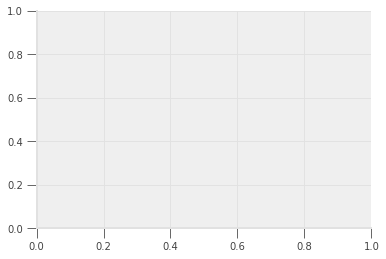

In [37]:
# Generate predictions

# Plot
fig, ax = plt.subplots()

# Make scatter of data

# Make scatter of predictions

([*back to text*](#exercise-0))

**Exercise 2**

Use the `metrics.mean_squared_error` function to evaluate the loss
function used by `sklearn` when it fits the model for us.

Read the docstring to learn which the arguments that function takes.

In [38]:
from sklearn import metrics

# your code here

([*back to text*](#exercise-1))

**Exercise 3**

Compare the mean squared error for the `lr_model` and the `sqft_lr_model`.

Which model has a better fit? Defend your choice.

([*back to text*](#exercise-2))

**Exercise 4**

Explore how you can improve the fit of the full model by adding additional
features created from the existing ones.

In [39]:
# your code here

([*back to text*](#exercise-3))

**Exercise 5**

Experiment with how the size of the holdout dataset can impact a diagnosis
of overfitting.

Evaluate only the `LinearRegression` model on the full feature set and use
the `model_selection.train_test_split` function with various values for
`test_size`.

([*back to text*](#exercise-4))

**Exercise 6**

Read the documentation for sklearn.tree.DecisionTreeRegressor and
then experiment with adjusting some regularization parameters to see how they
affect the fitted tree.

([*back to text*](#exercise-5))

**Exercise 7**

Fit a regression tree to the housing price data and use graphviz
to visualize the decision graph.

In [40]:
# your code here

([*back to text*](#exercise-6))

**Exercise 8**

Fit a random forest to the housing price data.

Compare the MSE on a testing set to that of lasso.

In [41]:
# Fit random forest and compute MSE

Produce a bar chart of feature importances for predicting house
prices.

([*back to text*](#exercise-7))

**Exercise 9**

In the pseudocode below, fill in the blanks for the generic MLP.

Note that this is inside a markdown cell because the code is not valid
Python.

```python
ws = [w1, w2, ..., wend]
bs = [b1, b2, ..., bend]

def eval_mlp(X, ws, bs, f):
    """
    Evaluate MLP-given weights (ws), bias (bs) and an activation (f)

    Assumes that the same activation is applied to all hidden layers
    """
    N = len(ws) - 1

    out = X
    for i in range(N):
        out = f(__)  # replace the __

    # For this step remember python starts counting at 0!
    return out@__ + __  # replace the __
```


([*back to text*](#exercise-8))

**Exercise 10**

Scale all variables in `X` by subtracting their mean and dividing by the
standard deviation.

Verify that the transformed data has mean 0 and standard deviation 1.

In [42]:
# your code here

([*back to text*](#exercise-9))

**Exercise 11**

Read the documentation for sklearn.neural_network.MLPRegressor and
use the full housing data to experiment with how adjusting layer depth, width, and other
regularization parameters affects prediction.

([*back to text*](#exercise-10))